# How to visualize MCMC diagnostics with ArviZ

[ArviZ](https://python.arviz.org/en/latest/) provides standard diagnostics and visual summaries (rank plots,
autocorrelation, ESS, and more) from an `InferenceData` container.

ArviZ is available whenever `pymc` is installed (it is a PyMC dependency). With
the default `sbi` install, you already have it. If you run without PyMC,
install ArviZ separately. This guide shows a minimal workflow with the high-level
API and how to retrieve the `InferenceData`.


### Minimal example

 Neural network successfully converged after 143 epochs.

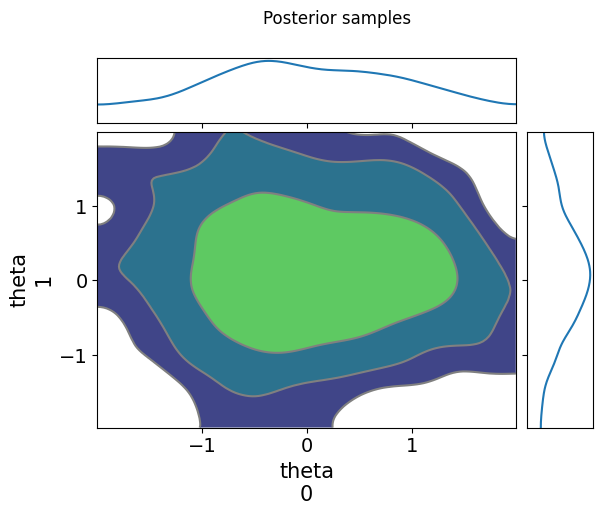

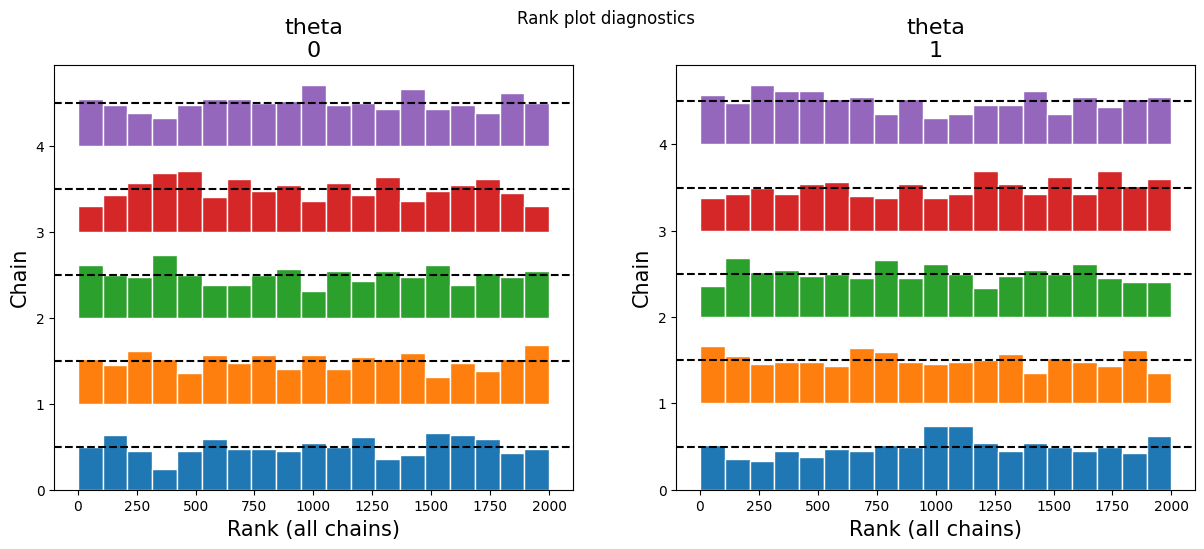

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import torch

from sbi.inference import NLE
from sbi.simulators.linear_gaussian import diagonal_linear_gaussian
from sbi.utils import BoxUniform

prior = BoxUniform(low=-2 * torch.ones(2), high=2 * torch.ones(2))
theta = prior.sample((1000,))
x = diagonal_linear_gaussian(theta)

inference = NLE(prior)
inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(prior=prior)

x_o = torch.zeros(1, 2)
posterior.sample((1000,), x=x_o, method="slice_np_vectorized", num_chains=5, show_progress_bars=False)

# Get samples per pain.
transformed = posterior.posterior_sampler.get_samples(group_by_chain=True)
samples_shape = transformed.shape
# Map samples back to the original parameter space for diagnostics.
samples = posterior.theta_transform.inv(
    torch.from_numpy(transformed).reshape(-1, samples_shape[-1])
).reshape(*samples_shape)
idata = az.convert_to_inference_data({posterior.param_name: samples})

# Visualize posterior samples and their dependencies.
az.plot_pair(idata, kind="kde", marginals=True)
plt.suptitle("Posterior samples")

# Check mixing with rank plots.
az.plot_rank(idata)
plt.suptitle("Rank plot diagnostics");

The pair plot summarizes posterior mass and dependencies across dimensions. The
rank plot is a quick check for mixing and convergence across chains.


## Other samplers

### PyMC (NUTS)
```python
import arviz as az

posterior.sample((500,), x=x_o, method="nuts_pymc", num_chains=2)
# PyMC samplers return an ArviZ InferenceData object directly.
idata = posterior.posterior_sampler.get_inference_data()
```

### Pyro (HMC/NUTS, no transform)
```python
import arviz as az

posterior.sample((500,), x=x_o, method="nuts_pyro", num_chains=2)
idata = az.from_pyro(posterior.posterior_sampler)
```
